<a href="https://colab.research.google.com/github/gemdata0/Covid-19-Tweet-Classification-Challange-NLP-/blob/main/Covid_19_Tweet_Classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -q tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 88.7 MB/s eta 0:00:00


In [2]:
import pandas as pd 
import numpy as np 
import string 

import tensorflow as tf 
import tensorflow_hub as hub
import tensorflow_text as text

from tensorflow.keras.optimizers import Adam

In [3]:
data = pd.read_csv('train.csv')
data.drop(['ID'], axis = 1, inplace = True)
data.head()

,text,target
0,The bitcoin halving is cancelled due to,1
1,MercyOfAllah In good times wrapped in its gran...,0
2,266 Days No Digital India No Murder of e learn...,1
3,India is likely to run out of the remaining RN...,1
4,In these tough times the best way to grow is t...,0


In [4]:
sentences = data['text'].to_list()
labels = data['target'].astype(int).to_list()

In [5]:
data['text'] = data['text'].str.replace('[{}]'.format(string.punctuation), '', regex = True)
data['text'] = data['text'].str.lower()

In [6]:
from sklearn.model_selection import train_test_split
sentences_train, sentences_test, labels_train, labels_test = train_test_split(sentences, labels, test_size = 0.3, random_state = 42)

In [7]:
input_text = tf.keras.layers.Input(shape = (), dtype = tf.string)
preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')(input_text)
encoder_output = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2', trainable = True)(preprocessor)

cls_token = encoder_output['pooled_output']

#reshaped_input = tf.expand_dims(cls_token, axis = -1)

In [8]:
dense_layer = tf.keras.layers.Dense(256, activation='relu')(cls_token)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense_layer)

model_bert = tf.keras.Model(inputs=input_text, outputs=output)

model_bert.compile(loss = 'binary_crossentropy', optimizer = Adam(0.0003), metrics = ['accuracy'])

In [9]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model_bert.fit(sentences_train, labels_train, epochs = 50, validation_data = (sentences_test, labels_test), callbacks = [early_stopping])

Epoch 1/50
116/116 [==============================] - 49s 251ms/step - loss: 0.3566 - accuracy: 0.8349 - val_loss: 0.2727 - val_accuracy: 0.8922
Epoch 2/50
116/116 [==============================] - 22s 189ms/step - loss: 0.1699 - accuracy: 0.9373 - val_loss: 0.2694 - val_accuracy: 0.8935
Epoch 3/50
116/116 [==============================] - 20s 173ms/step - loss: 0.0811 - accuracy: 0.9722 - val_loss: 0.3516 - val_accuracy: 0.8935
Epoch 4/50
116/116 [==============================] - 16s 135ms/step - loss: 0.0488 - accuracy: 0.9822 - val_loss: 0.4207 - val_accuracy: 0.8796
Epoch 5/50
116/116 [==============================] - 15s 129ms/step - loss: 0.0307 - accuracy: 0.9908 - val_loss: 0.5122 - val_accuracy: 0.8834


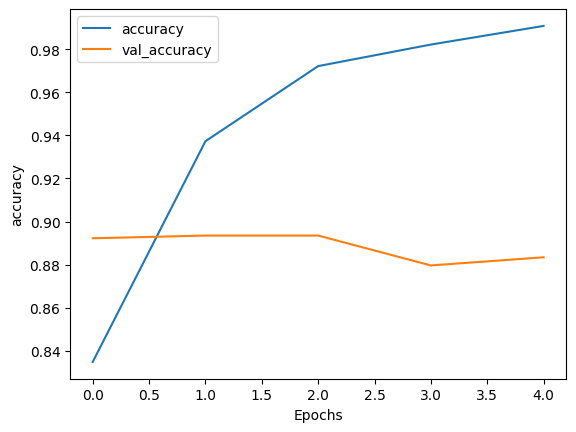

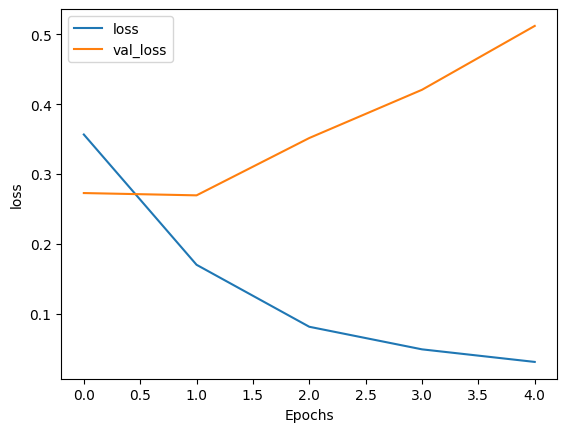

In [10]:
import matplotlib.pyplot as plt 

def plot_graph(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graph(history, 'accuracy')
plot_graph(history, 'loss')

In [11]:
new_data = pd.read_csv('test.csv')
new_data.head()

,ID,text
0,test_2,Why is explained in the video take a look
1,test_3,Ed Davey fasting for Ramadan No contest
2,test_4,Is Doja Cat good or do you just miss Nicki Minaj
3,test_8,How Boris Johnson s cheery wounded in action p...
4,test_9,Man it s terrible Not even a reason to get on ...


In [12]:
new_data['text'] = new_data['text'].str.replace('[{}]'.format(string.punctuation), '', regex = True)
new_data['text'] = new_data['text'].str.lower()

In [13]:
validation_sentences = new_data['text'].to_list()

In [14]:
validation_dataset = tf.data.Dataset.from_tensor_slices(validation_sentences)
validation_dataset = validation_dataset.batch(32)

In [15]:
prediction = model_bert.predict(validation_dataset)
prediction = pd.DataFrame(np.round(prediction))

62/62 [==============================] - 4s 63ms/step


In [16]:
new_data['prediction'] = prediction
new_data.head()

,ID,text,prediction
0,test_2,why is explained in the video take a look,1.0
1,test_3,ed davey fasting for ramadan no contest,0.0
2,test_4,is doja cat good or do you just miss nicki minaj,0.0
3,test_8,how boris johnson s cheery wounded in action p...,1.0
4,test_9,man it s terrible not even a reason to get on ...,0.0


In [18]:
new_data.to_excel(r'C:\Users\USER\Desktop\projects\Zindi\Covid-19 Tweet Classification\prediction.xlsx', index = False)